In [35]:

import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.callbacks import EarlyStopping
from helper_functions import walk_through_dir, plot_loss_curves, load_and_prep_image
from random import choice
from glob import glob
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, fbeta_score, f1_score, classification_report
from tensorflow.keras import regularizers

In [36]:
data_dir = "/app/dataset/chest_xray/"
walk_through_dir(dir_path=data_dir)

There are 3 directories and 0 images in '/app/dataset/chest_xray/'.
There are 2 directories and 0 images in '/app/dataset/chest_xray/test'.
There are 0 directories and 234 images in '/app/dataset/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in '/app/dataset/chest_xray/test/PNEUMONIA'.
There are 2 directories and 0 images in '/app/dataset/chest_xray/train'.
There are 0 directories and 1341 images in '/app/dataset/chest_xray/train/NORMAL'.
There are 0 directories and 3875 images in '/app/dataset/chest_xray/train/PNEUMONIA'.
There are 2 directories and 0 images in '/app/dataset/chest_xray/val'.
There are 0 directories and 8 images in '/app/dataset/chest_xray/val/NORMAL'.
There are 0 directories and 8 images in '/app/dataset/chest_xray/val/PNEUMONIA'.


In [37]:
# train & test dir
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'
val_dir = data_dir + 'val/'

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32 #32

##
# train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=42, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
# print('Validation Images:')
# validation_ds = tf.keras.utils.image_dataset_from_directory(val_dir, seed=42, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
# ##
print('Training Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.15,
    subset='training', seed=42, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.15,
    subset='validation', seed=42, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4434 files for training.


2024-03-16 05:20:43.494969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-16 05:20:43.506361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-16 05:20:43.506459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Validation Images:
Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [38]:
# Extract labels
class_names  = train_ds.class_names

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_names)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(class_names)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(class_names)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(class_names)

In [39]:
# Shape of the dataset
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [40]:
# Normalizing Pixel Values 

# Train Data 
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [41]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

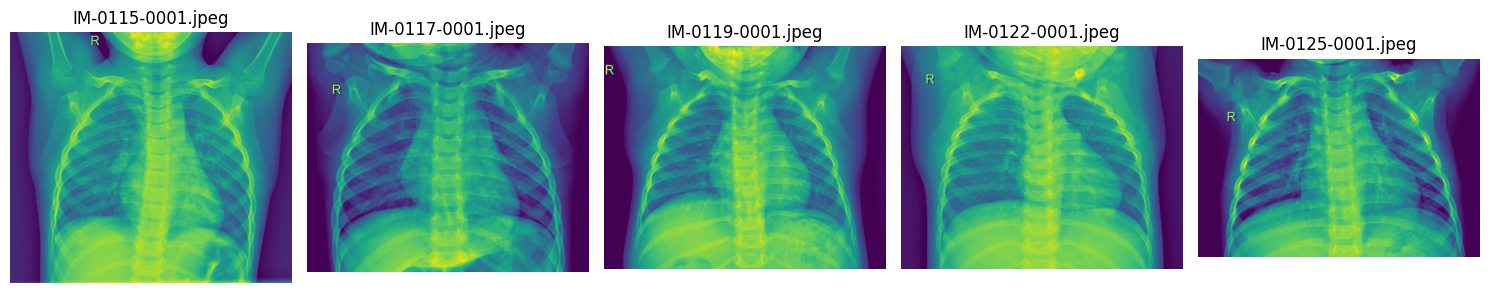

In [42]:
# Visualize image Normal
visualize_images(train_dir + "NORMAL", num_images=5)

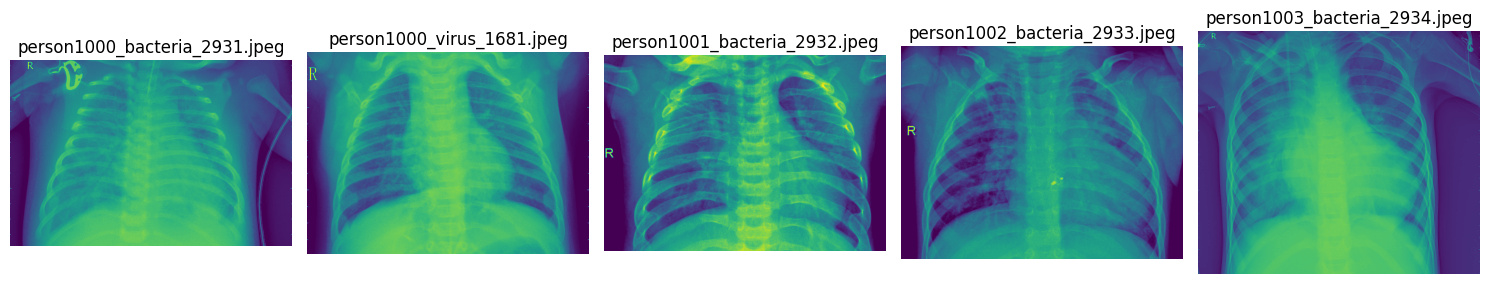

In [43]:
# Visualize image Normal
visualize_images(train_dir + "PNEUMONIA", num_images=5)

In [10]:
# Load the Xception base model without the top (classification) layer
base_model = keras.applications.Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model 
model = Sequential([
    base_model,
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.45),
    keras.layers.Dense(220, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense( len(class_names), activation="softmax") ])

# Compile
model.compile(optimizer=Adamax(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
model.summary()

83683744/83683744 [==============================] - 44s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 220)               450780    
                                                                 
 dropout_1 (Dropout)         (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                1

In [11]:
#Early_Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #5

#Fitting Model
history = model.fit(train_ds, epochs= 20, validation_data = validation_ds, # 20
                        callbacks = early_stopping)

Epoch 1/20


2024-03-16 01:47:24.258070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-03-16 01:47:25.865693: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f386debc840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-16 01:47:25.865715: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-16 01:47:25.868224: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-16 01:47:25.924531: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 [==============================] - 14s 68ms/step - loss: 0.2437 - accuracy: 0.8978 - val_loss: 0.2261 - val_accuracy: 0.9335
Epoch 2/20
139/139 [==============================] - 9s 62ms/step - loss: 0.1577 - accuracy: 0.9414 - val_loss: 0.1499 - val_accuracy: 0.9488
Epoch 3/20
139/139 [==============================] - 9s 62ms/step - loss: 0.1344 - accuracy: 0.9472 - val_loss: 0.1229 - val_accuracy: 0.9527
Epoch 4/20
139/139 [==============================] - 9s 63ms/step - loss: 0.1233 - accuracy: 0.9508 - val_loss: 0.1140 - val_accuracy: 0.9501
Epoch 5/20
139/139 [==============================] - 9s 62ms/step - loss: 0.1175 - accuracy: 0.9538 - val_loss: 0.1184 - val_accuracy: 0.9501
Epoch 6/20
139/139 [==============================] - 9s 62ms/step - loss: 0.1004 - accuracy: 0.9659 - val_loss: 0.1115 - val_accuracy: 0.9540
Epoch 7/20
139/139 [==============================] - 9s 63ms/step - loss: 0.1005 - accuracy: 0.9596 - val_loss: 0.1111 - val_accuracy: 0.9501
Epoch 8/2

In [12]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

25/25 [==============================] - 2s 51ms/step - loss: 0.1122 - accuracy: 0.9514
Validation Loss: 0.11219273507595062
Validation Accuracy: 0.9514066576957703


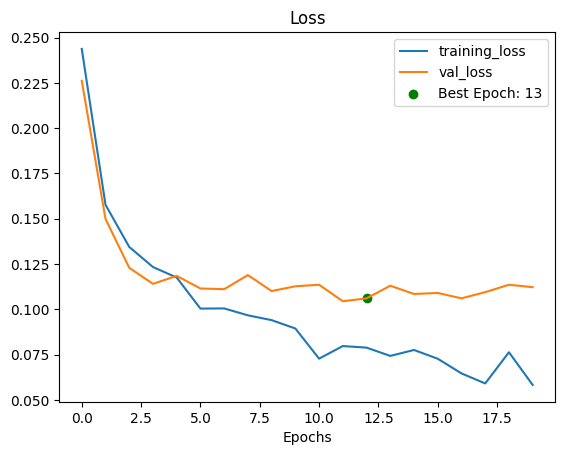

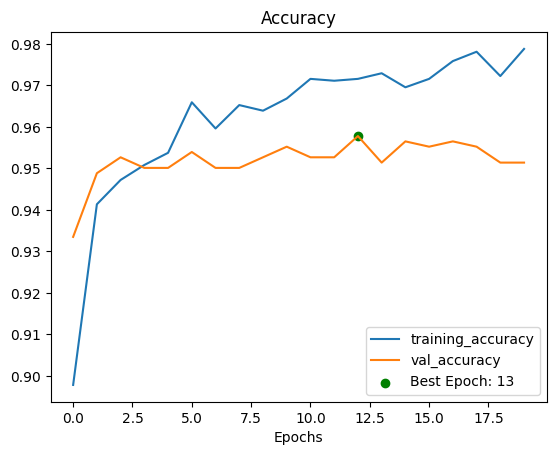

In [13]:
plot_loss_curves(history)

In [14]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) 
best_epoch

12

### Test predit model

1/1 [==============================] - 1s 571ms/step
Prediction value: 0.9999815225601196
Prediction label: PNEUMONIA
Label True: PNEUMONIA


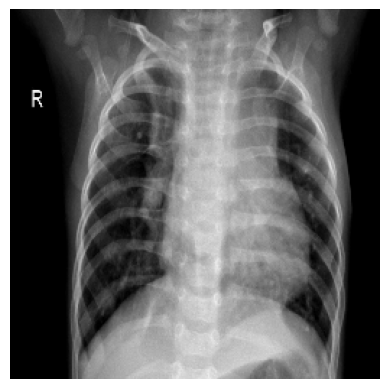

In [15]:
# select imagen 
img_path = glob(test_dir+"*/*.jpeg")
img_select = choice(img_path)
img_select

# load, tranform & pred img
img = load_and_prep_image(filename=img_select, img_shape=256,dimension=3)

# Make a prediction
pred = model.predict(tf.expand_dims(img, axis=0))

pred_class = class_names[pred.argmax()] # if more than one output, take the max


  # Plot the image and predicted class
plt.imshow(img)
print(f"Prediction value: {pred.max()}")
print(f"Prediction label: {pred_class}")
print(f"Label True: {img_select.split('/')[-2]}")
plt.axis(False);



### Confusion matrix

In [16]:
# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
  predictions = model.predict(images, verbose=0)
  predicted_labels.extend(np.argmax(predictions, axis=1))
  true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

array([[135,  99],
       [  3, 387]])

In [17]:
print(classification_report(y_true=true_labels, y_pred=predicted_labels , target_names= class_names ))

              precision    recall  f1-score   support

      NORMAL       0.98      0.58      0.73       234
   PNEUMONIA       0.80      0.99      0.88       390

    accuracy                           0.84       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.84      0.82       624



In [18]:
accuracy_score(y_true=true_labels, y_pred=predicted_labels)

0.8365384615384616

In [19]:
f1_score(y_true=true_labels, y_pred=predicted_labels)

0.8835616438356164

In [20]:
fbeta_score(y_true=true_labels, y_pred=predicted_labels, beta=.1)

0.7978567054500919

In [21]:
# modelo 1== 0.1 a 0.2 == acc = 842 f1= 887

## Modelo 2

In [ ]:
# change image size
IMAGE_SIZE = (224,224)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2,
    subset='training', seed=42, image_size=IMAGE_SIZE, batch_size=16)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2,
    subset='validation', seed=42, image_size=IMAGE_SIZE, batch_size=16)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42,
    image_size=IMAGE_SIZE, batch_size=16)

# class names
class_names  = train_ds.class_names

In [ ]:
# build model
# change image size
IMAGE_SIZE = (224,224)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2,
    subset='training', seed=42, image_size=IMAGE_SIZE, batch_size=16)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(train_dir, validation_split=0.2,
    subset='validation', seed=42, image_size=IMAGE_SIZE, batch_size=16)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42,
    image_size=IMAGE_SIZE, batch_size=16)

# class names
class_names  = train_ds.class_names

base_model_2 = keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = (224 , 224 , 3), pooling= 'max')

model_2 = Sequential([
    base_model_2,
    keras.layers.BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    keras.layers.Dropout(rate= 0.4 , seed = 75),
    keras.layers.Dense( len(class_names) , activation = 'softmax')
])

model_2.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

history_2 = model_2.fit(x= train_ds , epochs = 10, verbose = 1, validation_data= validation_ds, validation_steps = None , shuffle = False)

In [ ]:
# build model
base_model_2 = keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = (224 , 224 , 3), pooling= 'max')

model_2 = Sequential([
    base_model_2,
    keras.layers.BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    keras.layers.Dropout(rate= 0.4 , seed = 75),
    keras.layers.Dense( len(class_names) , activation = 'softmax')
])

model_2.compile(Adamax(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_2.summary()

In [ ]:
# run model
history_2 = model_2.fit(x= train_ds , epochs = 10, verbose = 1, validation_data= validation_ds, validation_steps = None , shuffle = False)

### Confusion matrix

In [ ]:
# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
  predictions = model_2.predict(images, verbose=0)
  predicted_labels.extend(np.argmax(predictions, axis=1))
  true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

In [ ]:
accuracy_score(y_true=true_labels, y_pred=predicted_labels)

In [ ]:
f1_score(y_true=true_labels, y_pred=predicted_labels)

In [ ]:
fbeta_score(y_true=true_labels, y_pred=predicted_labels, beta=.1)

In [ ]:
train_score = model_2.evaluate(train_ds , steps =16 , verbose = 1)
valid_score = model_2.evaluate(validation_ds , steps = 16 , verbose = 1)
test_score = model_2.evaluate(test_ds , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model_2.predict_generator(test_ds)
y_pred = np.argmax(preds , axis = 1)

In [ ]:
g_dict = test_ds.class_names
classes = list(g_dict.keys())
cm = confusion_matrix(test_ds.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Hugging Face

In [5]:
from datasets import load_dataset
import os

ds = load_dataset("keremberke/chest-xray-classification", name="full")


In [19]:
train_data = ds["train"]
test_data = ds["test"]
val_data = ds["validation"]
len(train_data), len(test_data), len(val_data)

(4077, 582, 1165)

In [25]:
def preprocessing(partition:str, data: object):
    os.makedirs(f"./dataset_hugging_chest/{partition}/NORMAL/", exist_ok=True)
    os.makedirs(f"./dataset_hugging_chest/{partition}/PNEUMONIA/", exist_ok=True)

    for i, sample in enumerate(data[partition]):
        img = sample["image"]
        label = sample["labels"]
        
        if label == 0:
            img.save(f"dataset_hugging_chest/{partition}/NORMAL/{i}.jpg")
        else:
            img.save(f"dataset_hugging_chest/{partition}/PNEUMONIA/{i}.jpg")        

In [26]:
preprocessing("test",ds)

In [7]:
train_data[0]

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/60340657865253-config-parquet-and-info-keremberke-chest-xray-cla-9d66ea8b/downloads/extracted/8202f7dd6f1edf5e674abe75990eb233fbbca4408e132a3acd5268bd99708e15/NORMAL/IM-0003-0001_jpeg.rf.3fffcf9c33575f8f928b017484f99a64.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}